# Lab 4: Data Imputation using an Autoencoder


In this lab, you will build and train an autoencoder to impute (or "fill in") missing data.

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features.

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link:https://colab.research.google.com/drive/1Yf_pcTstoy08-nq1WpPwpRjEYR_ELZuO

In [ ]:
import csv
import numpy as np
import random
import torch
import torch.utils.data

## Part 0

We will be using a package called `pandas` for this assignment.

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here:
https://pandas.pydata.org/pandas-docs/stable/install.html

In [ ]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [ ]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

<ipython-input-3-037957db2593>:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(


In [ ]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset.

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`.

Like numpy arrays and torch tensors,
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [ ]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names,
for example `df["race"]`, `df["hr"]`, or even index multiple columns
like below.

In [ ]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [ ]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1`

would increment everyone's age by 1.

In [ ]:
cols = ["age", "yredu", "capgain", "caploss", "workhr"]

for col in cols:
    print("Minimum", col,":", df[col].min())
    print("Maximum", col,":", df[col].max())
    print("Average", col,":", df[col].mean().round(1))
    print()
for col in cols:
    df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min()) #using min-max normalization
df[:3]

Minimum age : 17
Maximum age : 90
Average age : 38.6

Minimum yredu : 1
Maximum yredu : 16
Average yredu : 10.1

Minimum capgain : 0
Maximum capgain : 99999
Average capgain : 1077.6

Minimum caploss : 0
Maximum caploss : 4356
Average caploss : 87.3

Minimum workhr : 1
Maximum workhr : 99
Average workhr : 40.4



,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,0.301370,State-gov,77516,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,83311,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.00000,0.0,0.122449,United-States
2,0.287671,Private,215646,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.00000,0.0,0.397959,United-States


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [ ]:
# hint: you can do something like this in pandas
sum(df["sex"] == " Male")

21790

In [ ]:
print("Percentage of males in dataset: ", (sum(df["sex"] == " Male")/df["sex"].count())*100, "%")

print("Percentage of females in dataset: ", sum(df["sex"] == " Female")/df["sex"].count()*100, "%" )

Percentage of males in dataset:  66.92054912318419 %
Percentage of females in dataset:  33.07945087681583 %


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [ ]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [ ]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [ ]:
print("Number of records with missing features: ", df_with_missing.shape[0])
print("Percentage of records with missing features: ", round((df_with_missing.shape[0]/df.shape[0])*100, 2), "%")

Number of records with missing features:  1843
Percentage of records with missing features:  5.66 %


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [ ]:
possible_vals = df_not_missing["work"].unique()
for i in possible_vals:
  print(i)

 State-gov
 Self-emp-not-inc
 Private
 Federal-gov
 Local-gov
 Self-emp-inc
 Without-pay


We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`.

In [ ]:
data = pd.get_dummies(df_not_missing)

In [ ]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
1,0.452055,0.800000,0.00000,0.0,0.122449,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
2,0.287671,0.533333,0.00000,0.0,0.397959,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,True


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [ ]:
print(data.shape[1])

57


There are 57 columns. This number comes from the fact that we have a column for each continuous feature plus a binary true/false column for each category within a categorical feature. For example, the 'work' feature contributes to 7 of these 57 columns, for each of the 7 values that the 'work' feature takes on.

### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not
actually be "one-hot" -- the input may instead
contain real-valued predictions from our neural network.

In [ ]:
datanp = data.values.astype(np.float32)

In [ ]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.

    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.

    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`

    Examples:

    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    feature_to_extract = cat_values[feature]
    index = np.argmax(onehot)
    categorical_value = feature_to_extract[index]
    return categorical_value


print(get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work"))
print(get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work"))

State-gov
Private


In [ ]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [ ]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

indices = np.random.permutation(len(datanp))

train_end = int(0.7 * len(datanp))
valid_end = int(0.85 * len(datanp))

train_indices = indices[:train_end]
valid_indices = indices[train_end:valid_end]
test_indices = indices[valid_end:]

data_train = datanp[train_indices]
data_valid = datanp[valid_indices]
data_test = datanp[test_indices]

print("Number of items in training set: ", data_train.shape[0])
print("Number of items in validation set: ", data_valid.shape[0])
print("Number of items in test set: ", data_test.shape[0])

Number of items in training set:  21502
Number of items in validation set:  4608
Number of items in test set:  4608


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information
about ~11 features.

In [ ]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 20),
            nn.ReLU(),
            nn.Linear(20,11)
        )
        self.decoder = nn.Sequential(
            nn.Linear(11, 20),
            nn.ReLU(),
            nn.Linear(20, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

We use a sigmoid activation function to map the decoder output values to the range of [0,1]. This is neccesary because our input features for each record are in the range of [0,1], so we must apply this for the decoder to successfuly reconstruct the inputs.

## Part 3. Training [18]

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

Epoch [1/3], Train Accuracy: 0.4591, Valid Accuracy: 0.4580
Epoch [2/3], Train Accuracy: 0.5500, Valid Accuracy: 0.5519
Epoch [3/3], Train Accuracy: 0.5947, Valid Accuracy: 0.5922


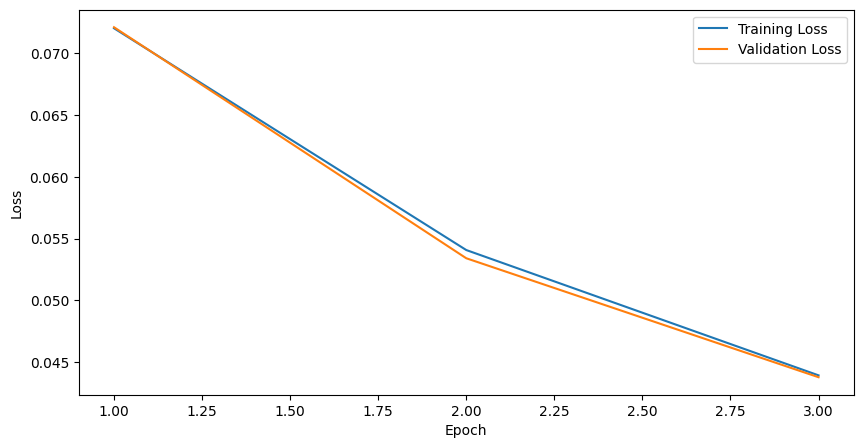

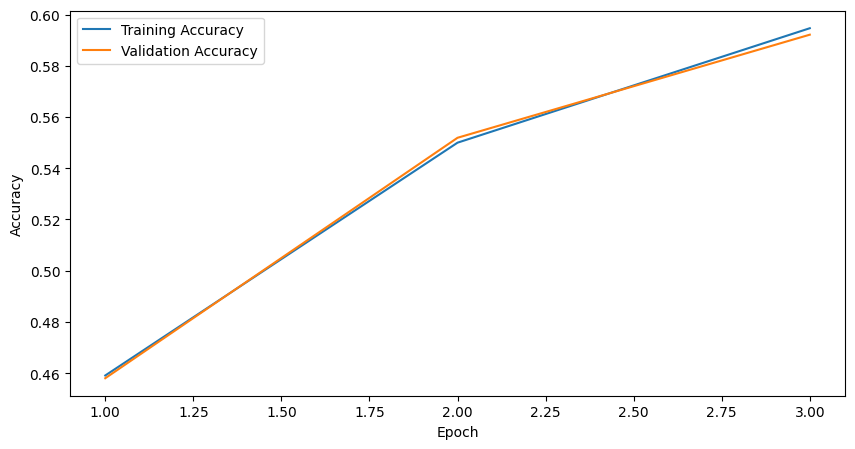

In [ ]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    epochs, train_loss, val_loss, train_acc, val_acc = [], [], [], [], []

    n = 1
    for epoch in range(num_epochs):
        model.train()
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        epochs.append(n)
        train_loss.append(get_loss(model, train_loader, criterion))
        val_loss.append(get_loss(model, valid_loader, criterion))
        train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy
        val_acc.append(get_accuracy(model, valid_loader))
        n += 1
        model.eval()
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Accuracy: {train_acc[-1]:.4f}, Valid Accuracy: {val_acc[-1]:.4f}')
        if epoch % 5 == 0:
            torch.save(model.state_dict(), f'model_{epoch}.pt')

    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def get_loss(model, data_loader, criterion):
    total_loss = 0

    for data in data_loader:
        out = model(zero_out_random_feature(data.clone()))
        loss = criterion(out, data)
        total_loss += loss.item()
    return total_loss / len(data_loader)

model = AutoEncoder()

#SAMPLE MODEL TO SHOW PLOTS
train_loader = torch.utils.data.DataLoader(data_train, batch_size=512, shuffle=True)
valid_loader = torch.utils.data.DataLoader(data_valid, batch_size=512, shuffle=False)
train(model, train_loader, valid_loader, num_epochs=3, learning_rate=0.01)

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few
iterations as part of your training curve.

In [ ]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature,
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the
    record. The returned "accuracy" measure is the percentage of times
    that our model is successful.

    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """

    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

Epoch [1/50], Train Accuracy: 0.5193, Valid Accuracy: 0.5205
Epoch [2/50], Train Accuracy: 0.5642, Valid Accuracy: 0.5647
Epoch [3/50], Train Accuracy: 0.5877, Valid Accuracy: 0.5875
Epoch [4/50], Train Accuracy: 0.6007, Valid Accuracy: 0.6003
Epoch [5/50], Train Accuracy: 0.6002, Valid Accuracy: 0.5974
Epoch [6/50], Train Accuracy: 0.5969, Valid Accuracy: 0.5923
Epoch [7/50], Train Accuracy: 0.5987, Valid Accuracy: 0.5940
Epoch [8/50], Train Accuracy: 0.6005, Valid Accuracy: 0.5947
Epoch [9/50], Train Accuracy: 0.6039, Valid Accuracy: 0.5980
Epoch [10/50], Train Accuracy: 0.6103, Valid Accuracy: 0.6055
Epoch [11/50], Train Accuracy: 0.6131, Valid Accuracy: 0.6067
Epoch [12/50], Train Accuracy: 0.6111, Valid Accuracy: 0.6057
Epoch [13/50], Train Accuracy: 0.6125, Valid Accuracy: 0.6077
Epoch [14/50], Train Accuracy: 0.6143, Valid Accuracy: 0.6109
Epoch [15/50], Train Accuracy: 0.6127, Valid Accuracy: 0.6088
Epoch [16/50], Train Accuracy: 0.6166, Valid Accuracy: 0.6115
Epoch [17/50], Tr

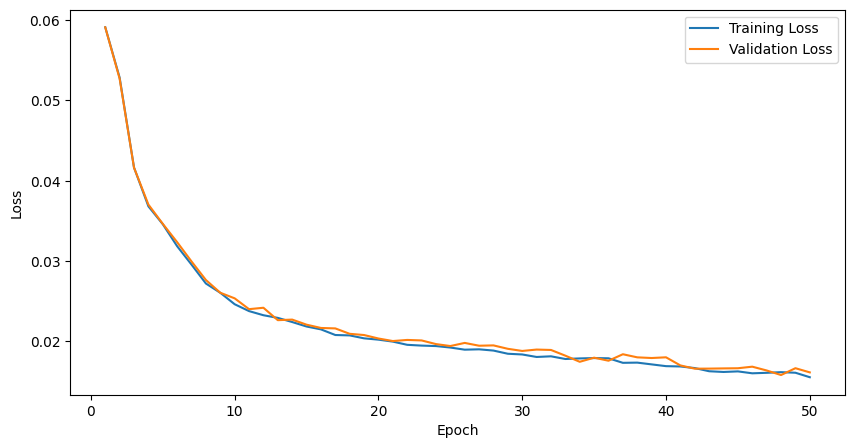

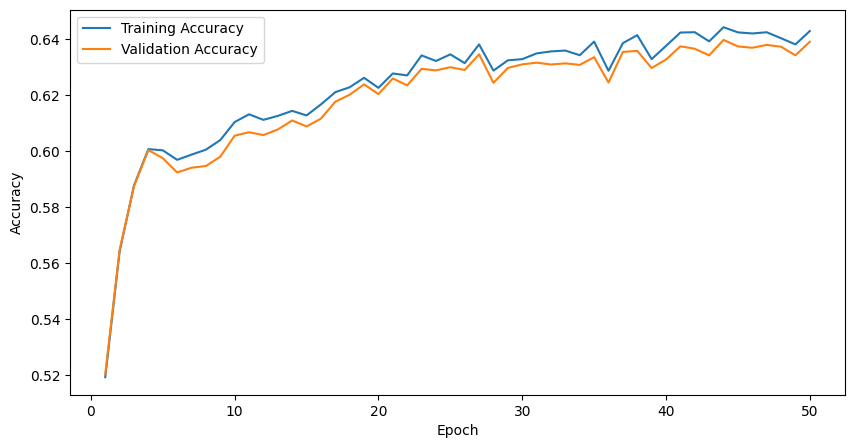

In [ ]:
train_loader = torch.utils.data.DataLoader(data_train, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(data_valid, batch_size=64, shuffle=False)

model = AutoEncoder()
#batch size 64, 50 epochs, 0.001 learning rate.
train(model, train_loader, valid_loader, num_epochs=50, learning_rate=0.001)

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you
chose the next set of hyperparameters to try.

# ***Model 1:***

Epochs:  100 \\
Batch Size:  64 \\
Learning Rate:  0.001

I chose to increase the number of epochs from 50 to 100 in this model, to see if i was slightly underfitting to the data.

Final train accuracy: 0.6541  \\
Final valid accuracy: 0.6472

Doubling the number of epochs slightly improved final train and validation accuracy, but nothing significant.

# ***Model 2:***

Epochs: 50 \\
Batch Size: 64 \\
Learning Rate: 0.0001 \\

I chose to decrease the learning rate from 0.001 to 0.0001, hopefully this can lead to better fine tuning of the weights to lead to better accuracy.

Final train accuracy: 0.6072 \\
Final valid accuracy: 0.6030

Decreasing the learning rate actually had a negative effect on the final train and validation accuracy. For the next two models, we will revert back to using a learning rate of 0.001

# ***Model 3:***

Epochs: 50 \\
Batch Size: 32  \\
Learning Rate: 0.001 \\

I chose to decrease the batch size to 32 in this model. This will lead to more iterations, which means more updates per epoch, which can lead to better train and val accuracies. I also choose to keep the learning rate at 0.001.

Final train accuracy: 0.6496 \\
Final valid accuracy: 0.6440

Changing the batch size from 64 to 32 resulted in an increase in final training and validation accuracy compared to the baseline model.

# ***Model 4:***

Epochs: 100 \\
Batch Size: 32 \\
Learning Rate: 0.001 \\

In the previous models, we see that decreasing batch size to 32 and increasing epochs to 100 slightly improves the model, so we create a model with both of these hyperparameter settings.

Final train accuracy: 0.6611 \\
Final valid accuracy: 0.6558 \\
This model achieved the best accuracies.

Epoch [1/100], Train Accuracy: 0.5745, Valid Accuracy: 0.5746
Epoch [2/100], Train Accuracy: 0.5957, Valid Accuracy: 0.5948
Epoch [3/100], Train Accuracy: 0.6111, Valid Accuracy: 0.6060
Epoch [4/100], Train Accuracy: 0.6114, Valid Accuracy: 0.6079
Epoch [5/100], Train Accuracy: 0.6109, Valid Accuracy: 0.6094
Epoch [6/100], Train Accuracy: 0.6105, Valid Accuracy: 0.6080
Epoch [7/100], Train Accuracy: 0.6220, Valid Accuracy: 0.6179
Epoch [8/100], Train Accuracy: 0.6223, Valid Accuracy: 0.6200
Epoch [9/100], Train Accuracy: 0.6189, Valid Accuracy: 0.6155
Epoch [10/100], Train Accuracy: 0.6195, Valid Accuracy: 0.6170
Epoch [11/100], Train Accuracy: 0.6249, Valid Accuracy: 0.6224
Epoch [12/100], Train Accuracy: 0.6256, Valid Accuracy: 0.6241
Epoch [13/100], Train Accuracy: 0.6288, Valid Accuracy: 0.6245
Epoch [14/100], Train Accuracy: 0.6248, Valid Accuracy: 0.6214
Epoch [15/100], Train Accuracy: 0.6316, Valid Accuracy: 0.6274
Epoch [16/100], Train Accuracy: 0.6315, Valid Accuracy: 0.6273
E

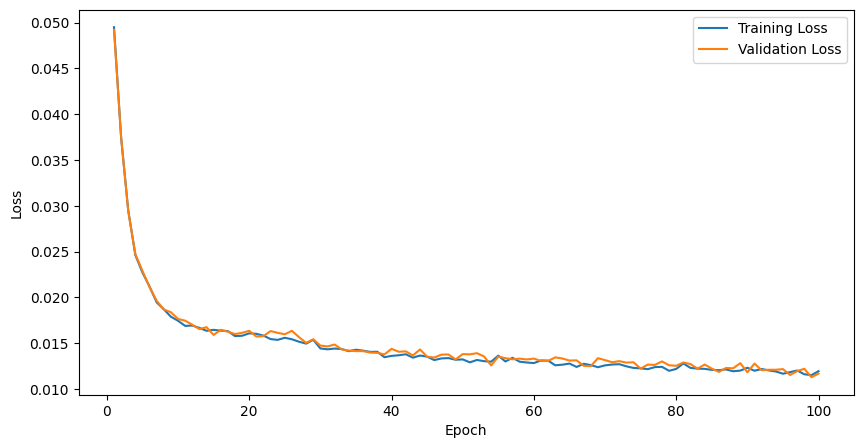

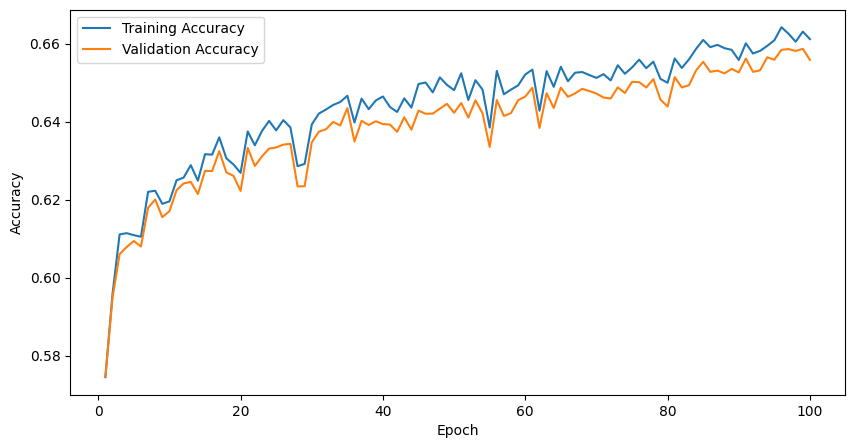

In [ ]:
train_loader = torch.utils.data.DataLoader(data_train, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(data_valid, batch_size=32, shuffle=False)

model4 = AutoEncoder()

train(model4, train_loader, valid_loader, num_epochs=100, learning_rate=0.001)

# Part 4. Testing [12 pt]

###Part (a) [2pt]
Compute and report the test accuracy.

In [ ]:
#Using model 4, as it produced the best train and val results.
test_loader = torch.utils.data.DataLoader(data_test, batch_size=32, shuffle=False)
test_accuracy = get_accuracy(model4, test_loader)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.6597945601851852


The test accuracy is 65.97%

### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set.

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [ ]:
from collections import Counter

most_common_values = {}
for feature in catcols:
    start_index = cat_index[feature]
    end_index = start_index + len(cat_values[feature])
    feature_values = data_test[:, start_index:end_index]
    feature_values = [tuple(row) for row in feature_values]
    most_common = Counter(feature_values).most_common(1)[0][0]
    most_common_values[feature] = most_common

correct = 0
total = 0
for record in data_test:
    for feature in catcols:
        start_index = cat_index[feature]
        end_index = start_index + len(cat_values[feature])
        actual_value = record[start_index:end_index]
        predicted_value = most_common_values[feature]
        if np.array_equal(actual_value, predicted_value):
            correct += 1
        total += 1



accuracy = correct / total
print("Baseline Model Test Accuracy:", accuracy)

Baseline Model Test Accuracy: 0.4583333333333333


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

Our test accuracy in part (a) is 65.89%. Our baseline test accuracy is 45.833%. This means that our autoencoder is perfoming well compared to the baseline, as it leads to significant improvement.

### Part (d) [1 pt]

Look at the first item in your test data.
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [ ]:
get_features(data_test[0])

{'work': 'Private',
 'marriage': 'Divorced',
 'occupation': 'Prof-specialty',
 'edu': 'Bachelors',
 'relationship': 'Not-in-family',
 'sex': 'Male'}

I do not think its reasonable that a human can guess that this person has a bachelors degree. Although the occupation of a person gives a decent guess of a persons education level, we see that this person's occupation is 'prof-specialty', which is 'one that requires highly specialized training and/or experience' [1]. Although most people in professional occupations such as engineers, accountants, lawyers are bachelors educated, many of these people can hold a masters or PhD degree, or possibly no degree at all for certain occupations (ie. software developers/engineers with no college degree is possible).



[1] https://www.betterteam.com/specialty-occupations#:~:text=A%20specialty%20occupation%20is%20one%20that%20requires%20highly%20specialized%20training,college%20or%20university%20to%20perform.

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [ ]:
first_record_tensor = torch.tensor(data_test[0]).view(1, 57)
modified_tensor = zero_out_feature(first_record_tensor, "edu")
output = model4(modified_tensor).detach().numpy()
predicted_education_level = get_feature(output[0], "edu")

print(predicted_education_level)

Prof-school


When we zero out education and feed this record through the model, we get a prediction of professional school, which is incorrect.

### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [ ]:
most_common_values
for i in most_common_values:
  print(get_categorical_value(most_common_values[i], i))

Private
Married-civ-spouse
Exec-managerial
HS-grad
Husband
Male


The most common education level is a high school graduate, so this is what our baseline model would have predicted.

In [ ]:
%%shell
jupyter nbconvert --to html "/content/Lab4_Data_Imputation.ipynb"

[NbConvertApp] Converting notebook /content/Lab4_Data_Imputation.ipynb to html
[NbConvertApp] Writing 1032870 bytes to /content/Lab4_Data_Imputation.html
